#Flight analisys in Brazil

This notebook was made with the goal of analyze the Brazilian air network and its regions.

The data utilized in this analisys were gathered through the dataset [Flights in Brazil](https://github.com/alvarofpp/dataset-flights-brazil).

##Preparing data

In [ ]:
# If the notebook ask to restart after running this cell, restart it.
!pip install nxviz=='0.6.3'

In [ ]:
# Importing necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
import nxviz as nv
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore') 

##Graph structure

It's an undirected graph.

#### Node attributes
The id of each node is the ICAO airport code.

| Column | Type | Description | Example |
| --- | --- | --- | --- |
| name | string | Airport name. | "GUARULHOS" |
| country | string | Country where the airport is located. | "BRASIL" |
| region | string | Airport region. | "SUDESTE" |

#### Edge attributes
| Column | Type | Description | Example |
| --- | --- | --- | --- |
| flight_count | int | Number of flights carried out between these airports. | 147 |
| distance | float | Distance in Km between these airports. | 543.0 |

In [ ]:
# Function to generate new graphml
def generateNewGraphml():
  # Load airports.csv
  !gdown https://drive.google.com/uc?id=1U_J96vlgcafe1Tg0r7c8udbeJ5Lw7eZT
  # Load anac.csv
  !gdown https://drive.google.com/uc?id=1CL6kX0u90v5V6m_acV7kaPNIl1z2ZhaJ
  
  df_airports = pd.read_csv('airports.csv')
  df_flights = pd.read_csv('anac.csv')

  # Create graph
  G = nx.Graph()

  # Add nodes
  for index, row in df_airports.iterrows():
    G.add_node(row['code'],
            name=row['name'],
            country=row['country'],
            region=row['region'],
            )

  # Add edges
  df_edges = df_flights[[
    'origin_airport_abbreviation',
    'destination_airport_abbreviation',
    'distance_flown_km',
  ]].dropna()
  df_edges = df_edges.groupby(df_edges.columns.tolist(), as_index=False).size()
  for index, row in df_edges.iterrows():
    if row['origin_airport_abbreviation'] == row['destination_airport_abbreviation']:
        continue
    G.add_edge(row['origin_airport_abbreviation'], row['destination_airport_abbreviation'], flight_count=row['size'], distance=row['distance_flown_km'])

  # Export to graphml
  nx.write_graphml(G, 'air_traffic_final.graphml')

In [ ]:
# Load air_traffic_final.graphml (File generated by the function above)
!gdown https://drive.google.com/uc?id=1m2pSWhyIp2tgIRjI9GlTj5lLkVutJPbN

Downloading...
From: https://drive.google.com/uc?id=1m2pSWhyIp2tgIRjI9GlTj5lLkVutJPbN
To: /content/air_traffic_final.graphml
100% 871k/871k [00:00<00:00, 53.7MB/s]


In [ ]:
# If you choose to run the cell above, running this one is not necessary since it will lead to the same result
generateNewGraphml()

Downloading...
From: https://drive.google.com/uc?id=1U_J96vlgcafe1Tg0r7c8udbeJ5Lw7eZT
To: /content/airports.csv
100% 87.6k/87.6k [00:00<00:00, 32.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CL6kX0u90v5V6m_acV7kaPNIl1z2ZhaJ
To: /content/anac.csv
100% 252M/252M [00:01<00:00, 246MB/s]


In [ ]:
G = nx.read_graphml('air_traffic_final.graphml')

In [ ]:
# Remove non brazilian nodes
nodesToRemove = [node[0] for node in list(G.nodes(data=True)) if node[1]['country'] != 'BRASIL']
G.remove_nodes_from(nodesToRemove)

In [ ]:
print('Number of airports (nodes):', G.number_of_nodes())
print('Number of routes (edges):', G.number_of_edges())

Número de aeroportos (nós): 495
Número de rotas (arestas): 3797


#Dividing subgraphs by region

In [ ]:
northeast_subgraph = nx.subgraph(G, [node for node in G.nodes if G.nodes[node]['region'] == "NORDESTE"])
north_subgraph = nx.subgraph(G, [node for node in G.nodes if G.nodes[node]['region'] == "NORTE"])
midwest_subgraph = nx.subgraph(G, [node for node in G.nodes if G.nodes[node]['region'] == "CENTRO-OESTE"])
southeast_subgraph = nx.subgraph(G, [node for node in G.nodes if G.nodes[node]['region'] == "SUDESTE"])
south_subgraph = nx.subgraph(G, [node for node in G.nodes if G.nodes[node]['region'] == "SUL"])

# Part 1: Assortativity

## Assortativity by region

In [ ]:
# Calculation of assortativity using region as attribute
nx.attribute_assortativity_coefficient(G, "region")

0.3999382371386459

Since the assortativity is positive, this means that airports form the same region tend to have an route between themselfs rather than having this route with airports from different regions.

## Generating the graphic with nxviz to analise the assortativity

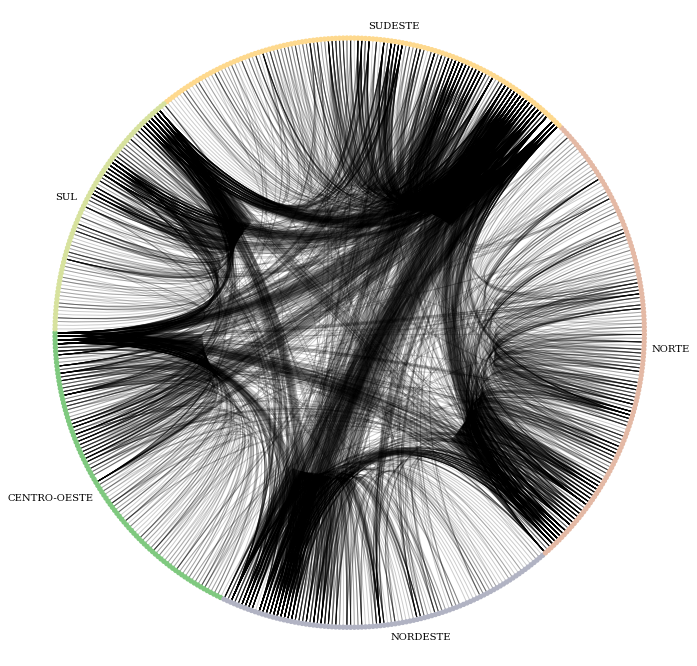

In [ ]:
# Create a Circos Plot
c = nv.CircosPlot(G,
                  node_color="region",
                  node_grouping="region",
                  node_order="region",
                  group_order="alphabetically",
                  group_legend=False,
                  node_labels=False,
                  group_label_position="middle",
                  group_label_color=False,
                  figsize=(15,12))

# Draw c to the screen
c.draw()

# Save figure
plt.savefig("region_assortativity.png", 
            format="png",
            dpi=400, 
            bbox_inches="tight",
            transparent=True)

# Display graph
plt.show()

The graph reinforces the assortativity mesaured above, the majority of routes in a region are destined to that same region.

# Part 2: Assortativity of the degree

## Bivariate analysis between vertex degree and mean number of neighbors

Generating the graph for bivariate analysis across the graph.

In [ ]:
def generateDegreeAssortativity(graph, name):
  # Average degree of neighbors
  degree, avg_neigh_degree = zip(*nx.average_degree_connectivity(graph).items())

  # Convert to list
  degree = list(degree)
  avg_neigh_degree = list(avg_neigh_degree)

  plt.style.use("fivethirtyeight")
  fig, ax = plt.subplots(1,1,figsize=(10,6))

  sns.regplot(degree, avg_neigh_degree,ax=ax)
  ax.set_title(f"{name.capitalize()}: Degree Assortativity")
  ax.set_xlabel("Node Degree")
  ax.set_ylabel("Average neigbhor degree")

  # Save figure
  plt.savefig(f"{name}_degree_assortativity.png", 
            format="png",
            dpi=400, 
            bbox_inches="tight",
            transparent=True)

  plt.show()

In [ ]:
nx.degree_assortativity_coefficient(G)

-0.1884609197836279

Since the degree assortativity is negative, this means that the airports with a higher neighbour degree have as neighbours airports with a lower degree.

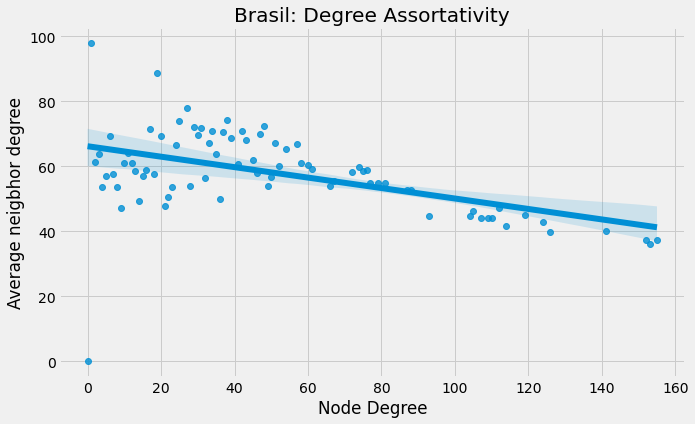

In [ ]:
generateDegreeAssortativity(G, 'brasil')

It is notable that as the degree of the node increases the average neighbour degree decreases. Descending line.

North subgraph degree assortativity -0.20857552820132058


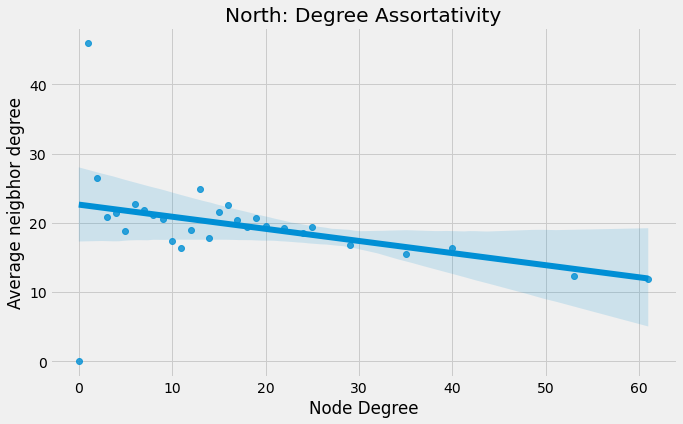


Northeast subgraph degree assortativity -0.3193797197533496


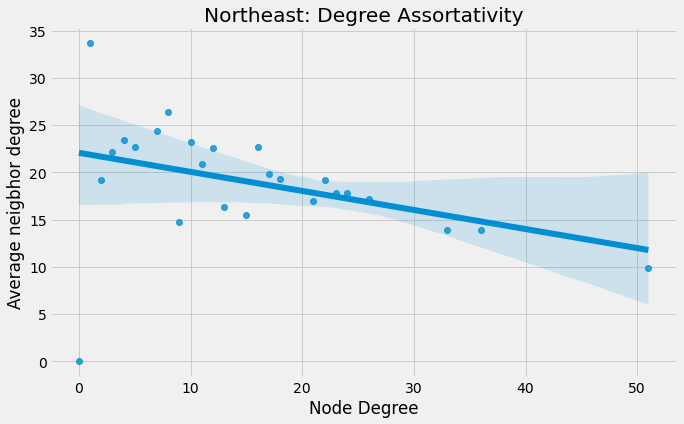


Midwest subgraph degree assortativity -0.3615640871358759


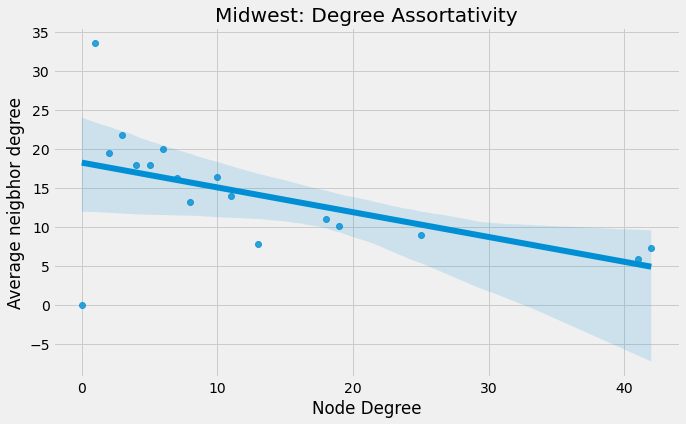


Southeast subgraph degree assortativity -0.37608031441009687


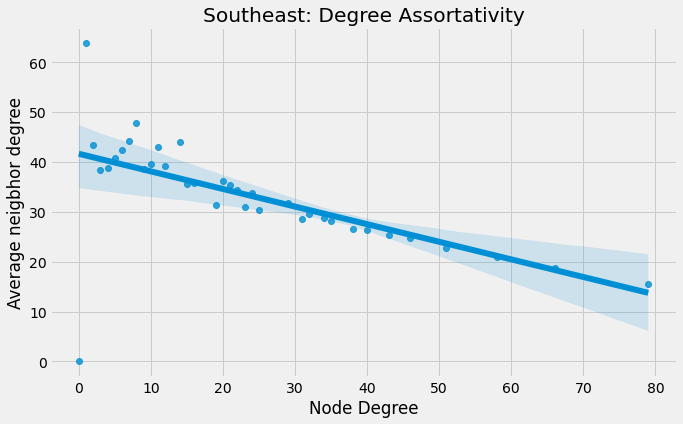


South subgraph degree assortativity -0.41366933460493477


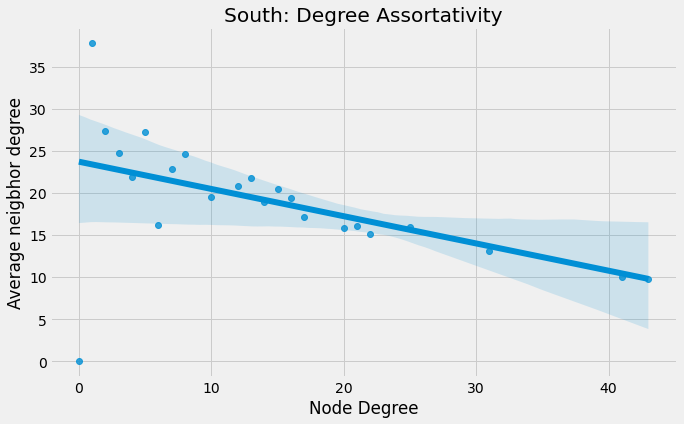

In [ ]:
print('North subgraph degree assortativity', nx.degree_assortativity_coefficient(north_subgraph))
generateDegreeAssortativity(north_subgraph, 'north')
print('\nNortheast subgraph degree assortativity', nx.degree_assortativity_coefficient(northeast_subgraph))
generateDegreeAssortativity(northeast_subgraph, 'northeast')
print('\nMidwest subgraph degree assortativity', nx.degree_assortativity_coefficient(midwest_subgraph))
generateDegreeAssortativity(midwest_subgraph, 'midwest')
print('\nSoutheast subgraph degree assortativity', nx.degree_assortativity_coefficient(southeast_subgraph))
generateDegreeAssortativity(southeast_subgraph, 'southeast')
print('\nSouth subgraph degree assortativity', nx.degree_assortativity_coefficient(south_subgraph))
generateDegreeAssortativity(south_subgraph, 'south')

As expected, every region follows the tendency of the Brazil analisys having even more negative degree assortativity. This means that in every region exists one or more airports that focus the number of routes. A highlight is the South region having the smallest degree assortativity in all regions.

# Part 3: Connected components from the brazilian air network

In [ ]:
# Creates a dictionary of the quantity and the porcentage of the nodes by region
validRegions = ['NORTE', 'NORDESTE', 'CENTRO-OESTE', 'SUDESTE', 'SUL']
def regionDiversity(graph):
  resultDict = {}
  totalNodes = graph.number_of_nodes()
  for validRegion in validRegions:
    quant = len([node for node in graph.nodes if graph.nodes[node]['region'] == validRegion])
    resultDict[validRegion] = (quant, quant / totalNodes * 100)
  return resultDict

In [ ]:
# Checking if the graph is connected
print('Is connected?', nx.is_connected(G))

Is connected? False


In [ ]:
# Obtain the number of connected components
numberConnectedComponents = nx.number_connected_components(G)
print('Number of connected components:', numberConnectedComponents)

Number of connected components: 6


In [ ]:
# Generating all subgraphs from connected components
connectedComponents = []
for index in range(0, numberConnectedComponents):
    subgraph = nx.subgraph(G, list(nx.connected_components(G))[index])
    connectedComponents.append(subgraph)

In [ ]:
# Subgraph 1 (GCC)
subgraph1 = connectedComponents[0]
print('Number of airports (nodes):', subgraph1.number_of_nodes())
regionPorcentage = regionDiversity(subgraph1)
for regionKey in regionPorcentage:
  regionData = regionPorcentage[regionKey]
  print(f"{regionKey:12}: Quantity: {regionData[0]:3}, Porcentage: {regionData[1]:.2f}%")

Number of airports (nodes): 490
NORTE       : Quantity: 126, Porcentage: 25.71%
NORDESTE    : Quantity:  91, Porcentage: 18.57%
CENTRO-OESTE: Quantity:  88, Porcentage: 17.96%
SUDESTE     : Quantity: 115, Porcentage: 23.47%
SUL         : Quantity:  70, Porcentage: 14.29%


In [ ]:
# Subgraph 2
subgraph2 = connectedComponents[1]
print('Number of airports (nodes):', subgraph2.number_of_nodes())
regionPorcentage = regionDiversity(subgraph2)
for regionKey in regionPorcentage:
  regionData = regionPorcentage[regionKey]
  print(f"{regionKey:12}: Quantity: {regionData[0]:3}, Porcentage: {regionData[1]:.2f}%")

Number of airports (nodes): 1
NORTE       : Quantity:   0, Porcentage: 0.00%
NORDESTE    : Quantity:   0, Porcentage: 0.00%
CENTRO-OESTE: Quantity:   0, Porcentage: 0.00%
SUDESTE     : Quantity:   1, Porcentage: 100.00%
SUL         : Quantity:   0, Porcentage: 0.00%


In [ ]:
# Subgraph 3
subgraph3 = connectedComponents[2]
print('Number of airports (nodes):', subgraph3.number_of_nodes())
regionPorcentage = regionDiversity(subgraph3)
for regionKey in regionPorcentage:
  regionData = regionPorcentage[regionKey]
  print(f"{regionKey:12}: Quantity: {regionData[0]:3}, Porcentage: {regionData[1]:.2f}%")

Number of airports (nodes): 1
NORTE       : Quantity:   0, Porcentage: 0.00%
NORDESTE    : Quantity:   0, Porcentage: 0.00%
CENTRO-OESTE: Quantity:   1, Porcentage: 100.00%
SUDESTE     : Quantity:   0, Porcentage: 0.00%
SUL         : Quantity:   0, Porcentage: 0.00%


In [ ]:
# Subgraph 4
subgraph4 = connectedComponents[3]
print('Number of airports (nodes):', subgraph4.number_of_nodes())
regionPorcentage = regionDiversity(subgraph4)
for regionKey in regionPorcentage:
  regionData = regionPorcentage[regionKey]
  print(f"{regionKey:12}: Quantity: {regionData[0]:3}, Porcentage: {regionData[1]:.2f}%")

Number of airports (nodes): 1
NORTE       : Quantity:   1, Porcentage: 100.00%
NORDESTE    : Quantity:   0, Porcentage: 0.00%
CENTRO-OESTE: Quantity:   0, Porcentage: 0.00%
SUDESTE     : Quantity:   0, Porcentage: 0.00%
SUL         : Quantity:   0, Porcentage: 0.00%


In [ ]:
# Subgraph 5
subgraph5 = connectedComponents[4]
print('Number of airports (nodes):', subgraph5.number_of_nodes())
regionPorcentage = regionDiversity(subgraph5)
for regionKey in regionPorcentage:
  regionData = regionPorcentage[regionKey]
  print(f"{regionKey:12}: Quantity: {regionData[0]:3}, Porcentage: {regionData[1]:.2f}%")

Number of airports (nodes): 1
NORTE       : Quantity:   0, Porcentage: 0.00%
NORDESTE    : Quantity:   1, Porcentage: 100.00%
CENTRO-OESTE: Quantity:   0, Porcentage: 0.00%
SUDESTE     : Quantity:   0, Porcentage: 0.00%
SUL         : Quantity:   0, Porcentage: 0.00%


In [ ]:
# Subgraph 6
subgraph6 = connectedComponents[5]
print('Number of airports (nodes):', subgraph6.number_of_nodes())
regionPorcentage = regionDiversity(subgraph6)
for regionKey in regionPorcentage:
  regionData = regionPorcentage[regionKey]
  print(f"{regionKey:12}: Quantity: {regionData[0]:3}, Porcentage: {regionData[1]:.2f}%")

Number of airports (nodes): 1
NORTE       : Quantity:   1, Porcentage: 100.00%
NORDESTE    : Quantity:   0, Porcentage: 0.00%
CENTRO-OESTE: Quantity:   0, Porcentage: 0.00%
SUDESTE     : Quantity:   0, Porcentage: 0.00%
SUL         : Quantity:   0, Porcentage: 0.00%


Note that the brazilian air network, over the analized graph, isn't connected. Altogether have been obtained 6 connected components on what one of these components focus 98,99% of all the air network and the 5 remaining connected components are made by isolated airports. The connected component with the majority of nodes can be classified as a giant connected component (GCC).

# Part 4: Simulated Scenario

Create an simulated scenario, where you want to make a travel with the following route:

* city 1 (Norte) to city 2 (Sul)
* city 2 (Sul) to city 3 (Nordeste)
* city 3 (Nordeste) to city 4 (Centro-Oeste)
* city 4 (Centro-Oeste) to city 5 (Sudeste)

In [ ]:
# Get random nodes from the valid regions and check if these nodes are inside the GCC
def getRandomNodes(subgraphGCC):
  northNode = random.choice(list(north_subgraph.nodes()))
  northeastNode = random.choice(list(northeast_subgraph.nodes()))
  midwestNode = random.choice(list(midwest_subgraph.nodes()))
  southeastNode = random.choice(list(southeast_subgraph.nodes()))
  southNode = random.choice(list(south_subgraph.nodes()))
  nodesToCheck = (northNode, southNode, northeastNode, midwestNode, southeastNode)
  nodesGCC = list(subgraphGCC.nodes())
  areValid = True
  for nodeToCheck in nodesToCheck:
    areValid = areValid and nodeToCheck in nodesGCC
  if areValid:
    return nodesToCheck
  else:
    return getRandomNodes(subgraphGCC)

In [ ]:
# Describe the shortest path between two airports
def describePath(airport1, airport2):
  node1 = G.nodes[airport1]
  node2 = G.nodes[airport2]
  path = nx.shortest_path(G, airport1, airport2, weight="distance")
  pathByNames = [G.nodes[airport]['name'] for airport in path]
  pathLength = len(path) - 1
  totalDistance = 0
  for index in range(0, pathLength):
    if index == pathLength - 1:
      continue
    actualAirport = path[index]
    nextAirport = path[index + 1]
    totalDistance += G.edges[actualAirport, nextAirport]['distance']
  print(f"Path between {node1['name']} ({node1['region']}) and {node2['name']} ({node2['region']})")
  print('Path length:', pathLength)
  print('Path distance: {} Km'.format(totalDistance))
  print(' => '.join(pathByNames))

In [ ]:
# Simulating scenario
subgraphGCC = connectedComponents[0]
northNode, southNode, northeastNode, midwestNode, southeastNode = getRandomNodes(subgraphGCC)
describePath(northNode, southNode)
describePath(southNode, northeastNode)
describePath(northeastNode, midwestNode)
describePath(midwestNode, southeastNode)

Path between TABATINGA (NORTE) and PORECATU (SUL)
Path length: 6
Path distance: 3083.0 Km
TABATINGA => PORTO VELHO => RONDONÓPOLIS => PRESIDENTE PRUDENTE => ASSIS => LONDRINA => PORECATU
Path between PORECATU (SUL) and ILHÉUS (NORDESTE)
Path length: 7
Path distance: 1443.0 Km
PORECATU => LONDRINA => BOTUCATU => CAMPINAS => ANGRA DOS REIS => RIO DE JANEIRO => GOVERNADOR VALADARES => ILHÉUS
Path between ILHÉUS (NORDESTE) and COCALINHO (CENTRO-OESTE)
Path length: 2
Path distance: 1109.0 Km
ILHÉUS => GOIÂNIA => COCALINHO
Path between COCALINHO (CENTRO-OESTE) and ARMAÇÃO DOS BÚZIOS (SUDESTE)
Path length: 6
Path distance: 1315.0 Km
COCALINHO => GOIÂNIA => BARRETOS => CAMPINAS => ANGRA DOS REIS => RIO DE JANEIRO => ARMAÇÃO DOS BÚZIOS


# Part 5: Clustering coeficient

Develop a study about the clustering coefficient given the brazilian air network, as well as the air network of each region (Norte, Nordeste, Centro-Oeste, Sul e Sudeste).

In [ ]:
print('Brasil clustering coeficient: {:.3f}'.format(nx.average_clustering(G)))
print('North clustering coeficient: {:.3f}'.format(nx.average_clustering(north_subgraph)))
print('Northeast clustering coeficient: {:.3f}'.format(nx.average_clustering(northeast_subgraph)))
print('Midwest clustering coeficient: {:.3f}'.format(nx.average_clustering(midwest_subgraph)))
print('Southeast clustering coeficient: {:.3f}'.format(nx.average_clustering(southeast_subgraph)))
print('South clustering coeficient: {:.3f}'.format(nx.average_clustering(south_subgraph)))

Brasil clustering coeficient: 0.601
North clustering coeficient: 0.591
Northeast clustering coeficient: 0.403
Midwest clustering coeficient: 0.529
Southeast clustering coeficient: 0.618
South clustering coeficient: 0.560


Note that the clustering coeficient of the brazilian air network stays around 0.6, which means that the network have an intermediate feature between an fully connected network and a network with a star topology.
Analyzing all the regions, it is observed that north, midwest, southeast and south regions follows the brazilian air network coeficient with values between 0.52 and 0.62. However, the northeast reagion stand out with a clustering coeficient too low compared with the other regions, meaning that exists some airport that focus the routes in that region, approaching a star topology.